### Full Name : Radin Khayyam
### Student Number : 99101579


# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

def prepare_data(batch_size=64, train_ratio=0.8):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [2]:
def explore_data(data_loader):
    images, labels = next(iter(data_loader))

    # Plot sample images
    fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
    fig.suptitle("Sample Images", fontsize=16)
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap="gray")
        ax.axis('off')
        ax.set_title(f'{labels[i].item()}')
    plt.show()

    # Plot label distribution
    labels_all = []
    for _, batch_labels in data_loader:
        labels_all.extend(batch_labels.numpy())

    plt.figure(figsize=(8, 4))
    plt.hist(labels_all, bins=np.arange(11) - 0.5, edgecolor='black')
    plt.xticks(range(10))
    plt.title('Label Distribution')
    plt.xlabel('Digit')
    plt.ylabel('Frequency')
    plt.show()


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.83MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.98MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



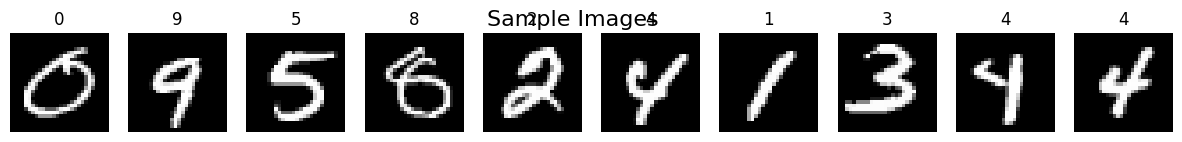

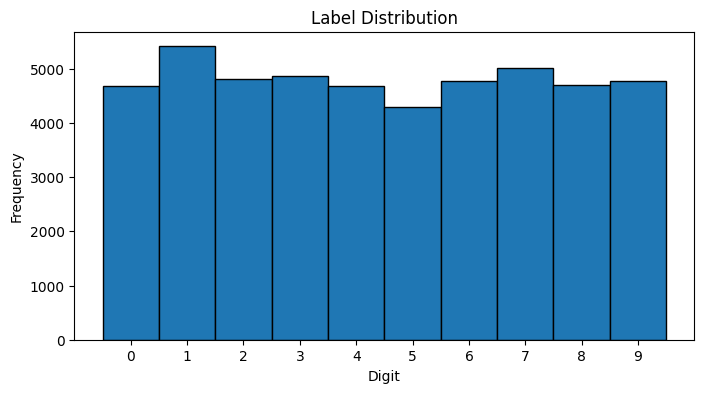

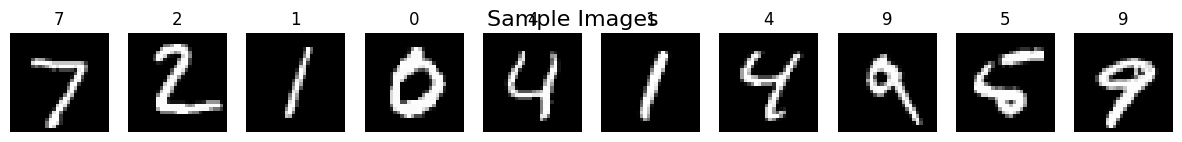

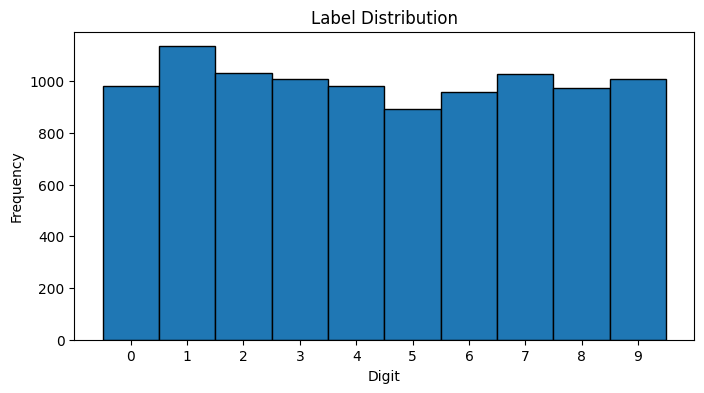

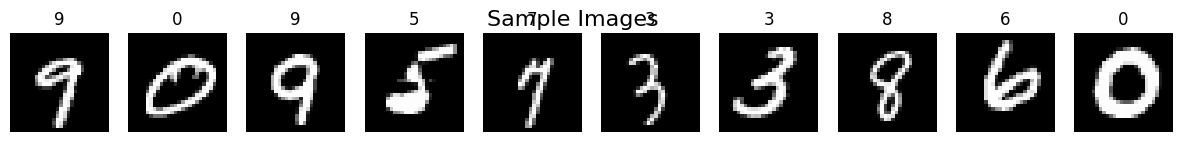

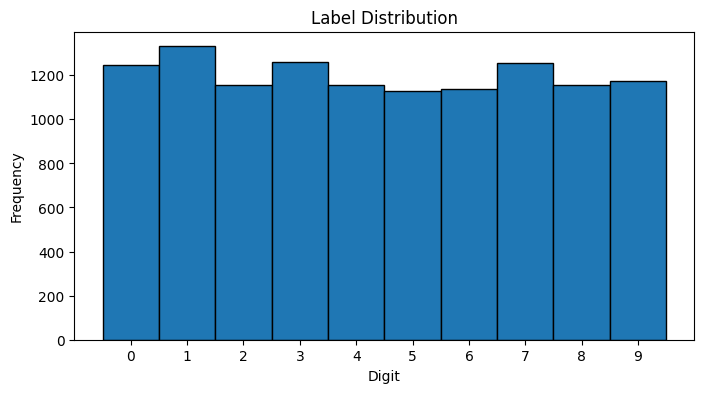

In [3]:
train_loader, val_loader, test_loader = prepare_data()
explore_data(train_loader)
explore_data(test_loader)
explore_data(val_loader)

Prepare the data for use with the CART algorithm by flattening the images.

In [4]:
def prepare_data_for_cart(data_loader):

    flattened_images = []
    labels = []

    for images, batch_labels in data_loader:
        # flatten each image in the batch from 28x28 to 784
        images_flattened = images.view(images.size(0), -1)

        flattened_images.append(images_flattened)
        labels.extend(batch_labels.numpy())

    flattened_images = torch.cat(flattened_images).numpy()
    labels = np.array(labels)

    return flattened_images, labels

In [5]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

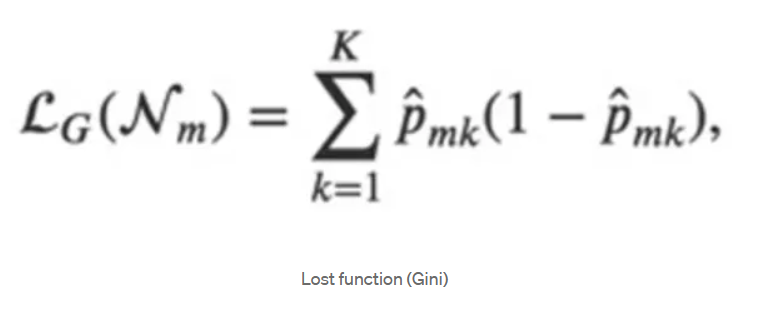

In [6]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
      self.feature = feature
      self.threshold = threshold
      self.left = left
      self.right = right
      self.value = value

class DecisionTree_CART:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        # Implement recursive tree building here
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        # stop conditions
        if (depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # find the best split
        best_feature, best_threshold = self._find_best_split(X, y)

        # if no valid split was found, return a leaf node
        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # split the dataset
        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold
        left_child = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)

    def _find_best_split(self, X, y):
        # Implement best split finding here
        best_gini = float("inf")
        best_feature, best_threshold = None, None
        num_samples, num_features = X.shape

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                # split the dataset
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold

                # clculate the Gini impurity for this split
                gini = self._calculate_gini_split(y, left_indices, right_indices)

                # if this split is better, record it
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_gini_split(self, y, left_indices, right_indices):
        left_labels = y[left_indices]
        right_labels = y[right_indices]
        n = len(y)
        n_left, n_right = len(left_labels), len(right_labels)

        # calculate the weighted gini impurity
        gini_left = self._gini_impurity(left_labels)
        gini_right = self._gini_impurity(right_labels)
        weighted_gini = (n_left / n) * gini_left + (n_right / n) * gini_right
        return weighted_gini

    def _gini_impurity(self, y):
        # Implement gini impurity calculation here
        m = len(y)
        if m == 0:
            return 0
        p_k = np.bincount(y) / m  # proportions of each class
        return np.sum(p_k * (1 - p_k))

    def _most_common_label(self, y):
        # return the most common label in y
        return np.bincount(y).argmax()

    def predict(self, X):
        # Implement prediction here
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        # recursive function to traverse the tree for a given sample
        if node.value is not None:
            return node.value
        if x[node.feature] < node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.

CART Implementation Accuracy for depth 1: 0.2004
CART Implementation Accuracy for depth 3: 0.4961
CART Implementation Accuracy for depth 5: 0.6736
CART Implementation Accuracy for depth 7: 0.7941
CART Implementation Accuracy for depth 9: 0.8501
scikit-learn DecisionTree Accuracy for depth 1: 0.2004
scikit-learn DecisionTree Accuracy for depth 3: 0.4961
scikit-learn DecisionTree Accuracy for depth 5: 0.6736
scikit-learn DecisionTree Accuracy for depth 7: 0.7942
scikit-learn DecisionTree Accuracy for depth 9: 0.8506


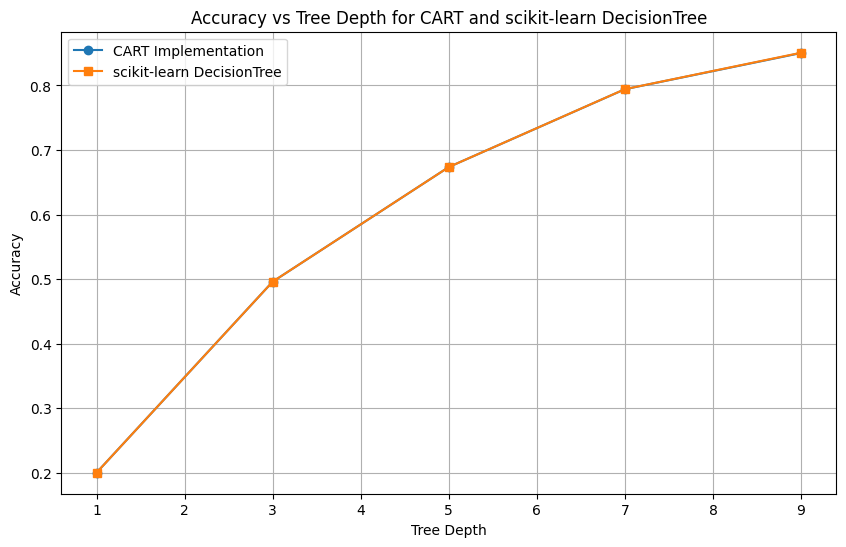

In [11]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Prepare data
train_loader, val_loader, test_loader = prepare_data()
X_train, y_train = prepare_data_for_cart(train_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

# # CART implementation

depths = [1,3,5,7,9]
cart_accuracies = []

for depth in depths:
    tree = DecisionTree_CART(max_depth=depth)
    tree.fit(X_train, y_train)
    predictions = tree.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    cart_accuracies.append(accuracy)
    print(f"CART Implementation Accuracy for depth {depth}: {accuracy:.4f}")

# scikit-learn's DecisionTreeClassifier
sklearn_accuracies = []

for depth in depths:
    sklearn_tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    sklearn_tree.fit(X_train, y_train)
    sklearn_predictions = sklearn_tree.predict(X_test)
    accuracy = accuracy_score(y_test, sklearn_predictions)
    sklearn_accuracies.append(accuracy)
    print(f"scikit-learn DecisionTree Accuracy for depth {depth}: {accuracy:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(depths, cart_accuracies, label='CART Implementation', marker='o')
plt.plot(depths, sklearn_accuracies, label='scikit-learn DecisionTree', marker='s')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Depth for CART and scikit-learn DecisionTree')
plt.legend()
plt.grid(True)
plt.show()


## Question
What is the difference between ID3 and CART algorithm




The ID3 and CART algorithms are both decision tree methods but differ in their splitting criteria and applications. ID3 uses information gain based on entropy to choose splits, favoring divisions that maximize the purity of the nodes. It’s primarily designed for classification tasks with categorical features and typically results in multiway splits (more than two branches) for features with multiple levels. Originally, ID3 doesn’t support pruning, which can lead to more complex trees and potential overfitting.

In contrast, CART uses Gini impurity for classification tasks and mean squared error (MSE) for regression, making it versatile for both classification and regression problems. CART always creates binary splits (two branches), regardless of feature type, and supports both continuous and categorical features directly. Additionally, CART has built-in post-pruning to prevent overfitting, making it more robust and widely applicable in practice compared to ID3.



